# percent-allocate

Maintain a percent allocation of a security in account

In [1]:
# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Define target_percent and band

In [5]:
target_percent = 50
band = 3

sma200_band = 3.5/100

Define Strategy Class 

In [6]:
class Strategy(object):

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        self._tlog.initialize(self._capital)

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self._ts, i)
            shares = 0

            # adjust shares
            if ((self._tlog.percent(close) > target_percent+band or
                self._tlog.percent(close) < target_percent-band)
                and close > row.sma200*(1+sma200_band)
                and not end_flag):
                # adjust shares to target_percent
                shares = self._tlog.adjust_percent(date, close, target_percent, self._symbol)   
            # close out
            elif (close < row.sma200*(1-sma200_band)
                  or end_flag):
                # adjust shares to 0
                shares = self._tlog.adjust_percent(date, close, 0, self._symbol)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, close))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, close))

            # record daily balance
            self._dbal.append(date, high, low, close, self._tlog.shares)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)

        # Add technical indicator: 200 day sma
        sma200 = SMA(self._ts, timeperiod=200)
        self._ts['sma200'] = sma200
        
        self._ts, self._start = pf.finalize_timeseries(self._ts, self._start)

        self._tlog = pf.TradeLog()
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal, self._capital)
        return stats

Run Strategy

In [7]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [8]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [9]:
rlog.tail(10)

,date,price,shares,entry_exit,symbol
34,2015-08-21,179.89,80,exit,SPY
35,2016-04-01,191.24,77,entry,SPY
36,2017-02-09,216.59,5,exit,SPY
37,2017-11-28,250.42,5,exit,SPY
38,2018-10-29,255.95,67,exit,SPY
39,2019-03-18,276.68,61,entry,SPY
40,2019-12-26,321.05,4,exit,SPY
41,2020-03-09,272.63,57,exit,SPY
42,2020-06-03,312.18,54,entry,SPY
43,2020-06-08,323.20,54,exit,SPY


In [10]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,symbol
23,2012-01-10,109.42,2013-05-14,143.75,34.33,205.98,6,13130.00,SPY
24,2012-01-10,109.42,2014-02-24,163.39,53.97,323.84,6,13453.85,SPY
25,2012-01-10,109.42,2014-12-26,187.78,78.36,391.82,5,13845.67,SPY
26,2012-01-10,109.42,2015-08-21,179.89,70.47,5637.78,80,19483.45,SPY
27,2016-04-01,191.24,2017-02-09,216.59,25.35,126.73,5,19610.18,SPY
28,2016-04-01,191.24,2017-11-28,250.42,59.17,295.87,5,19906.05,SPY
29,2016-04-01,191.24,2018-10-29,255.95,64.71,4335.34,67,24241.38,SPY
30,2019-03-18,276.68,2019-12-26,321.05,44.38,177.50,4,24418.89,SPY
31,2019-03-18,276.68,2020-03-09,272.63,-4.05,-230.84,57,24188.05,SPY
32,2020-06-03,312.18,2020-06-08,323.20,11.02,595.08,54,24783.13,SPY


In [11]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-06-02,34188.05,34188.05,34188.05,0,34188.05,-
2020-06-03,34244.21,34067.09,34188.05,54,17330.33,O
2020-06-04,34232.33,34020.65,34143.77,54,17330.33,-
2020-06-05,34678.91,34456.97,34574.69,54,17330.33,-
2020-06-08,34783.13,34783.13,34783.13,0,34783.13,X


Generate strategy stats - display all available stats

In [12]:
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2020-06-08
beginning_balance                                            10000
ending_balance                                            34783.13
total_net_profit                                          24783.13
gross_profit                                              25219.17
gross_loss                                                 -436.04
profit_factor                                                57.84
return_on_initial_capital                                   247.83
annual_return_rate                                            4.80
trading_period                           26 years 6 months 28 days
pct_time_in_market                                           75.10
total_num_trades                                                33
trades_per_year                                               1.24
num_winning_trades                                            

Run Benchmark

In [13]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()

1993-11-11 00:00:00 BUY  215 SPY @ 46.38
2020-06-08 00:00:00 SELL 215 SPY @ 323.20


Retrieve benchmark logs

In [14]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [15]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                   1993-11-11
end                                                     2020-06-08
beginning_balance                                            10000
ending_balance                                            69517.38
total_net_profit                                          59517.38
gross_profit                                              59517.38
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                   595.17
annual_return_rate                                            7.57
trading_period                           26 years 6 months 28 days
pct_time_in_market                                          100.00
total_num_trades                                                 1
trades_per_year                                               0.04
num_winning_trades                                            

Plot Equity Curves: Strategy vs Benchmark

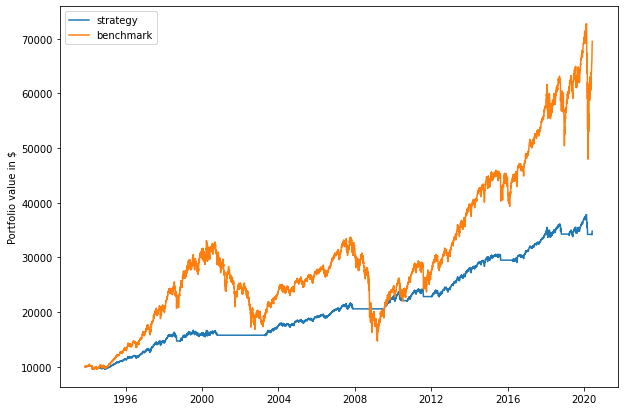

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

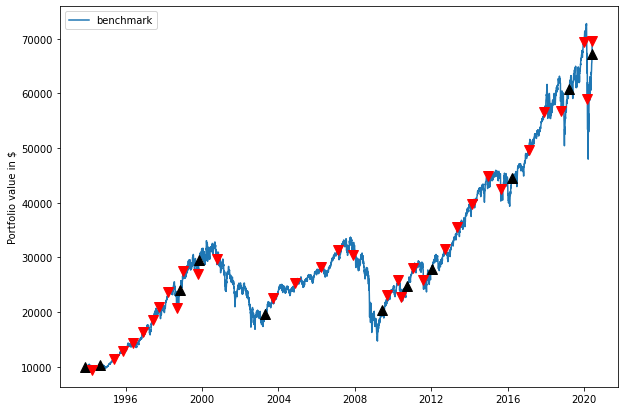

In [17]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,4.80,7.57
max_closed_out_drawdown,-10.19,-56.42
drawdown_annualized_return,-2.12,-7.45
drawdown_recovery,-0.30,-1.42
best_month,7.58,23.06
worst_month,-9.61,-31.38
sharpe_ratio,0.79,0.48
sortino_ratio,0.87,0.61
monthly_std,1.59,4.54


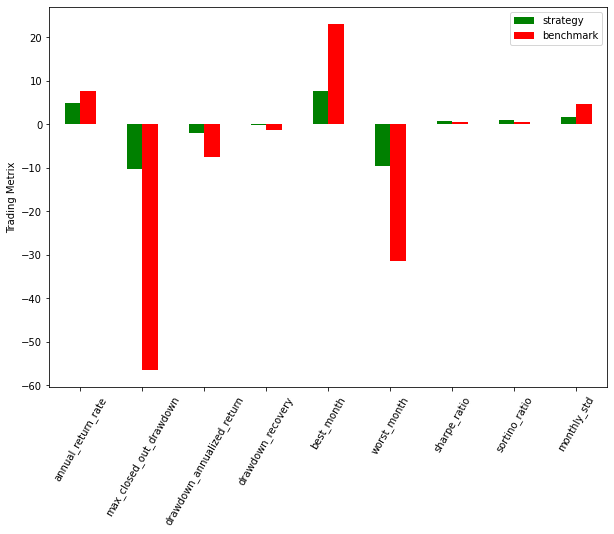

In [18]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df